[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/fonnesbeck/pymc_sdss_2024/blob/master/notebooks/Section3-Bayesian_Computation.ipynb)

# Bayesian Computation

Lets take a look at [Bayes formula](https://en.wikipedia.org/wiki/Bayes%27_theorem):

$$P(\theta|x) = \frac{P(x|\theta) P(\theta)}{P(x)}$$

We have $P(\theta|x)$, the probability of our model parameters $\theta$ given the data $x$ and thus our quantity of interest. To compute this we multiply the prior $P(\theta)$ (what we think about $\theta$ before we have seen any data) and the likelihood $P(x|\theta)$, i.e. how we think our data is distributed. This nominator is pretty easy to solve for.

However, lets take a closer look at the denominator. $P(x)$ which is also called the evidence (i.e. the evidence that the data x was generated by this model). We can compute this quantity by integrating over all possible parameter values:
$$P(x) = \int_\Theta P(x, \theta) \, \mathrm{d}\theta$$

This is the key difficulty with Bayes formula -- while the formula looks innocent enough, for even slightly non-trivial models you just can't compute the posterior in a closed-form way. 

Bayesian analysis often requires integration over multiple dimensions that is intractable both via analytic methods or standard methods of numerical integration.
However, it is often possible to compute these integrals by simulating
(drawing samples) from posterior distributions. For example, consider the expected value of a random variable $\mathbf{x}$:

$$E[\mathbf{x}] = \int \mathbf{x} f(\mathbf{x}) d\mathbf{x}, \qquad\mathbf{x} = x_1, \ldots ,x_k$$

where $k$ (the dimension of vector $x$) is perhaps very large. If we can produce a reasonable number of random vectors $\{{\bf x_i}\}$, we can use these values to approximate the unknown integral. This process is known as *Monte Carlo integration*. In general, MC integration allows integrals against probability density functions:

$$I = \int h(\mathbf{x}) f(\mathbf{x}) \mathbf{dx}$$

to be estimated by finite sums:

$$\hat{I} = \frac{1}{n}\sum_{i=1}^n h(\mathbf{x}_i),$$

where $\mathbf{x}_i$ is a sample from $f$. This estimate is valid and useful because:

-   By the strong law of large numbers:

$$\hat{I} \rightarrow I   \text{   with probability 1}$$

-   Simulation error can be measured and controlled:

$$Var(\hat{I}) = \frac{1}{n(n-1)}\sum_{i=1}^n (h(\mathbf{x}_i)-\hat{I})^2$$

And let's assume we could somehow generate samples from this unnormalized distribution. In that case we could approximate the full posterior quite easily:

In [1]:
from itertools import takewhile

import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st

## Inverse CDF sampling

Given a probability density function, $p(x)$, the cumulative density function is given by 

$$
\operatorname{cdf}(x) = \int_0^x p(t)~dt
$$

Note that the value $\operatorname{cdf}(x)$ is "the probability that a value is less than $x$", and is between 0 and 1. 

Text(0.5, 1.0, 'Normal cumulative density function')

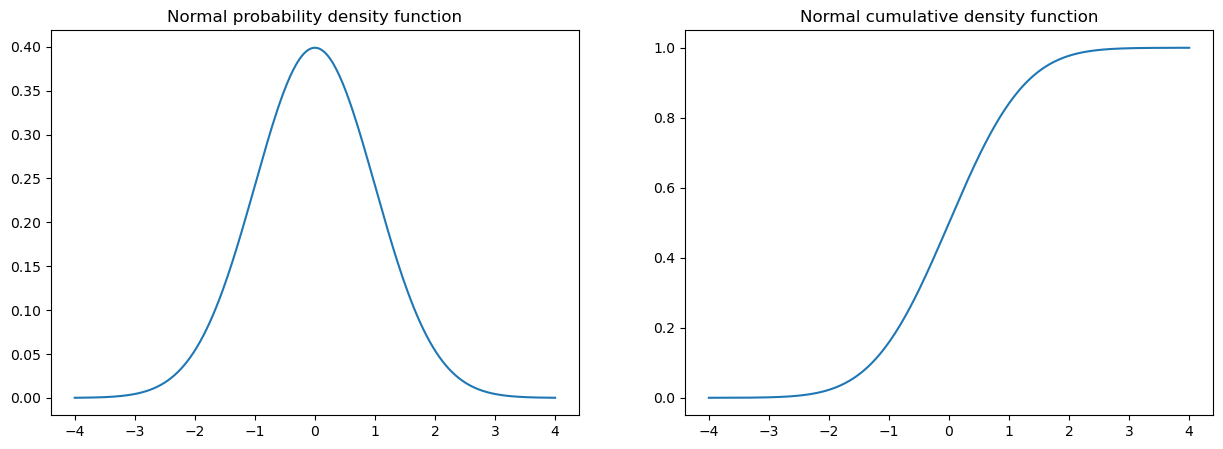

In [2]:
rv = st.norm(0, 1)

t = np.linspace(-4, 4, 300)

fig, axes = plt.subplots(ncols=2, figsize=(15, 5))

axes[0].plot(t, rv.pdf(t))
axes[0].set_title('Normal probability density function')
axes[1].plot(t, rv.cdf(t))
axes[1].set_title('Normal cumulative density function')

If we can *invert* the cumulative density function, we have a function $\operatorname{cdf}^{-1}(t)$, where $0 \leq t \leq 1$. We can use this function to draw random values:

1. Draw $u \sim U(0, 1)$
2. Use $y = \operatorname{cdf}^{-1}(u)$ as your sample

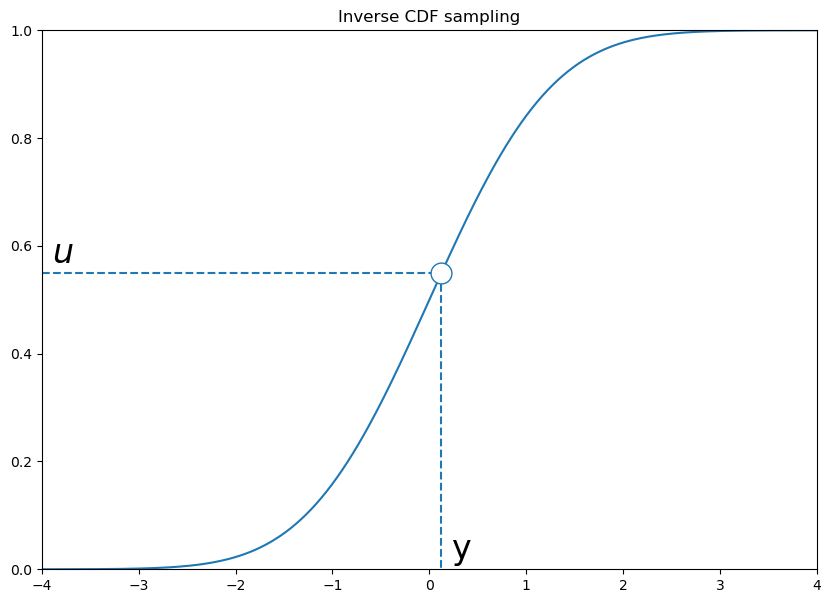

In [3]:
np.random.seed(0)
rv = st.norm(0, 1)

t = np.linspace(-4, 4, 300)
u = np.random.rand()

fig, ax = plt.subplots(figsize=(10, 7))

ax.plot(t, rv.cdf(t), color='C0')
ax.text(t.min() + 0.1, u + 0.02, '$u$', fontdict={"fontsize": 24})
ax.hlines(u, t.min(), rv.ppf(u), linestyles='dashed', color='C0')
ax.vlines(rv.ppf(u), u, 0, linestyles='dashed', color='C0')
bg_color = ax.get_facecolor()
ax.plot(rv.ppf(u), u, 'o', mfc=bg_color, ms=15)
ax.text(rv.ppf(u) + 0.1, 0.02, 'y', fontdict={"fontsize": 24})
ax.set_xlim(t.min(), t.max())
ax.set_ylim(0, 1)
ax.set_title('Inverse CDF sampling');

### Exercise: Inverse CDF sampling

Complete the following function that implements inverse CDF sampling for the normal distribution. There is a cell below to visually check your implementation.

In [4]:
st.norm, st.gamma.ppf

(<scipy.stats._continuous_distns.norm_gen at 0x7f5332ae34a0>,
 <bound method rv_continuous.ppf of <scipy.stats._continuous_distns.gamma_gen object at 0x7f53317e95b0>>)

In [5]:
def sample(draws, inv_cdf):
    """Draw samples using the inverse CDF of a distribution.
    
    Parameters
    ----------
    draws : int
        Number of draws to return
    inv_cdf : function
        Gives the percentile of the distribution the argument falls in."""
    # output should be an array of size (draws,), distributed according to inv_cdf
    u = np.random.random(draws)
    return inv_cdf(u)

inv_cdf_normal = st.norm.ppf

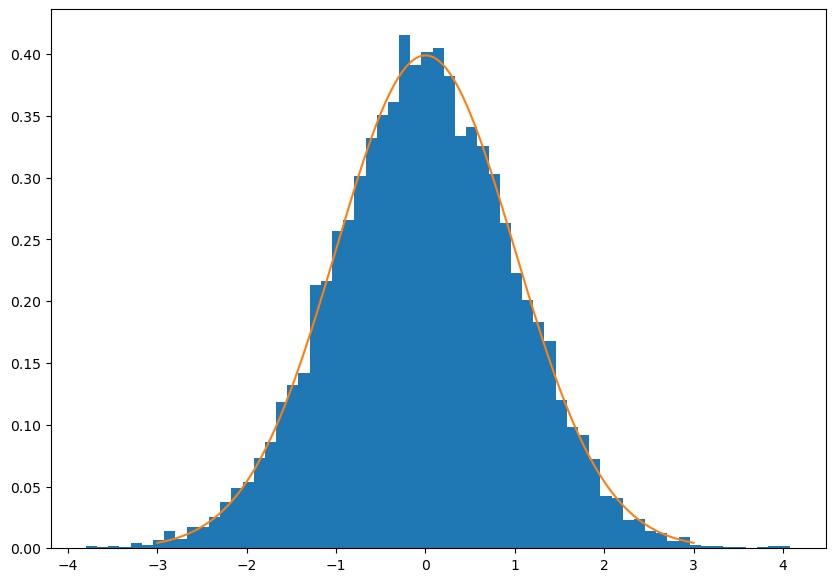

In [6]:
fig, ax = plt.subplots(figsize=(10, 7))

# Should look normally distributed!
ax.hist(sample(10_000, inv_cdf_normal), bins='auto', density=True)
x = np.linspace(-3, 3, 500)
ax.plot(x, st.norm.pdf(x))

### Exercise: Inverse CDF sampling for exponential distribution (calculus required)

The probability density function of the exponential distribution is 

$$
p(x | \lambda) = \lambda e^{-\lambda x}
$$

Calculate the cumulative density function, invert it, and use the `sample` function above to sample from the exponential function.

Again, there is a plot below to check your implementation.

In [7]:
def inv_cdf_exponential(u, lam=1): 
    # Should return an array of shape `u.shape`
    return -np.log(1 - u) / lam

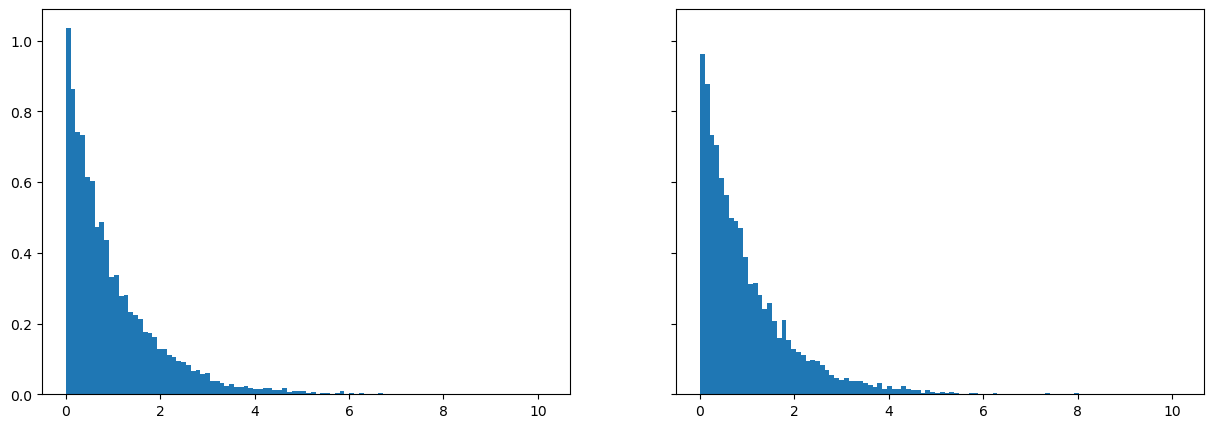

In [8]:
fig, axes = plt.subplots(ncols=2, figsize=(15, 5), sharex=True, sharey=True)
draws = 10_000

# Two histograms should look the same
axes[0].hist(st.expon(scale=1.).rvs(draws), bins='auto', density=True)
axes[1].hist(sample(draws, inv_cdf_exponential), bins='auto', density=True);

### Hints for previous exercise

The cumulative density function is

$$
\operatorname{cdf}(x) = 1-e^{-\lambda x}.
$$

Invert the cumulative density function by solving 
$$
y = 1-e^{-\lambda x}
$$ 

for $x$ in terms of $y$.


## Rejection Sampling

Most integrals are hard or impossible to do. Also, if we are iterating on a statistical model, we may want a method that works without requiring rederiving a formula for generating samples. Further, in Bayesian data analysis, we may not know a *normalizing constant*: we may only know 

$$
\tilde{p}(x) = \frac{1}{Z_p}p(x),
$$

for some constant $Z_p$ ("constant" here is with respect to $x$). In order to sample, first we

1. Choose a proposal distribution $q$ that you know how to sample from
2. Choose a number $k$, so that $kq(x) \geq \tilde{p}(x)$ for all $x$

Then, we repeatedly 

1. Draw a $z$ from $q$
2. Draw a $u$ from $\operatorname{Uniform}(0, kq(z))$
3. If $u \leq p(x)$, accept the draw, otherwise, reject.

Importantly, every "rejection" is wasted computation! We will explore methods for having less wasted computation later.

In [9]:
def mixture_of_gaussians():
    rvs = (st.norm(-3, 1), st.norm(0, 1), st.norm(3, 1))
    probs = (0.5, 0.2, 0.3)
    def pdf(x):
        return sum(p * rv.pdf(x) for p, rv in zip(probs, rvs))
    return pdf

<>:13: SyntaxWarning: invalid escape sequence '\c'
<>:22: SyntaxWarning: invalid escape sequence '\s'
<>:13: SyntaxWarning: invalid escape sequence '\c'
<>:22: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_1791073/1122266797.py:13: SyntaxWarning: invalid escape sequence '\c'
  ax.plot(t, k * q.pdf(t), '-', label='$k \cdot \mathcal{N}(z | 0, 3)$')
/tmp/ipykernel_1791073/1122266797.py:22: SyntaxWarning: invalid escape sequence '\s'
  ax.plot(z, u, 'rx', label='$u \sim U(0, k\cdot\mathcal{N}(z | 0, 3))$', ms=15, mfc=bg_color)


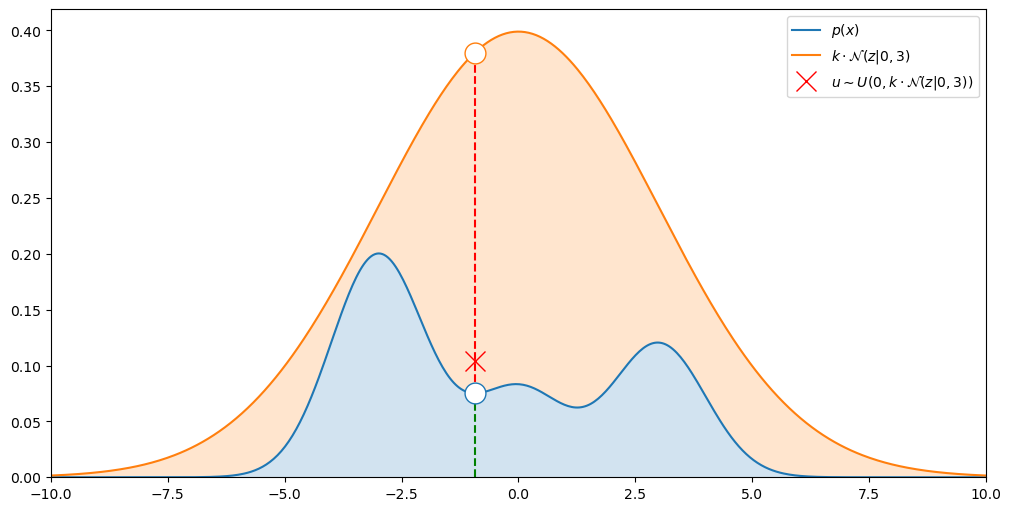

In [10]:
np.random.seed(6)
pdf = mixture_of_gaussians()
q = st.norm(0, 3)
z = q.rvs()
u = np.random.rand() * q.pdf(z)
k = 3

fig, ax = plt.subplots(figsize=(10, 5), constrained_layout=True)

t = np.linspace(-10, 10, 500)
ax.plot(t, pdf(t), '-', label='$p(x)$')
ax.fill_between(t, 0, pdf(t), alpha=0.2)
ax.plot(t, k * q.pdf(t), '-', label='$k \cdot \mathcal{N}(z | 0, 3)$')
ax.fill_between(t, pdf(t), k * q.pdf(t), alpha=0.2)

bg_color = ax.get_facecolor()
ax.vlines(z, 0, pdf(z), linestyles='dashed', color='green')
ax.vlines(z, pdf(z), k * q.pdf(z), linestyles='dashed', color='red')

# ax.plot(z, 0, 'o', label='z', ms=15, mfc=bg_color)
ax.plot(z, pdf(z), 'o', color='C0', ms=15, mfc=bg_color)
ax.plot(z, u, 'rx', label='$u \sim U(0, k\cdot\mathcal{N}(z | 0, 3))$', ms=15, mfc=bg_color)
ax.plot(z, k * q.pdf(z), 'o', color='C1', ms=15, mfc=bg_color)

# ax.plot(z * np.ones(4), np.array([0, pdf(z), u, k * q.pdf(z)]), 'ko', ms=15, mfc=bg_color)

ax.set_ylim(bottom=0)
ax.set_xlim(t.min(), t.max())
ax.legend()

### Rejection Sampling Example

Sample from the pdf returned by `mixture_of_gaussians` using rejection sampling. We will implement this as a Python generator, and yield the proposed draw, `z`, as well as whether it was accepted. You should assume `proposal_dist` comes from `scipy.stats`, so it has a `.rvs()` method that samples, and a `.pdf` method that evaluates the probability density function at a point.

If $kq(x)$ is not larger than $\tilde{p}(x)$, throw an exception!

The cell below has a plot to check your implementation.

In [11]:
# Rejection sampler code here
def rejection_sampler(pdf, proposal_dist, k):
    while True:
        z = proposal_dist.rvs()
        q_dist = proposal_dist.pdf(z)
        u = k * np.random.rand() * q_dist
        assert k * q_dist >= pdf(z)
        if u <= pdf(z):
            accept = True
        else:
            accept = False
        yield z, accept

def gen_samples(draws, sampler):
    samples = []
    for n_draws, (z, accept) in enumerate(sampler, start=1):
        if accept:
            samples.append(z)
            if len(samples) == draws:
                return np.array(samples), n_draws

In [12]:
pdf = mixture_of_gaussians()
proposal_dist = st.norm(0, 3)
k = 4
N = 10_000

samples, draws = gen_samples(N, rejection_sampler(pdf, proposal_dist, k))

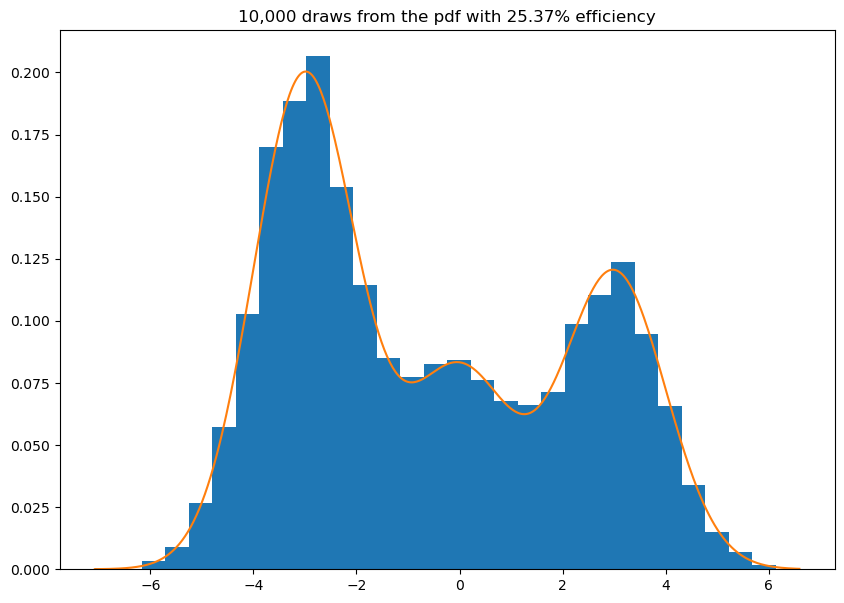

In [13]:
fig, ax = plt.subplots(figsize=(10, 7))

t = np.linspace(samples.min(), samples.max(), 500)

# This histogram should look very similar to the pdf that is plotted
ax.hist(samples, bins='auto', density=True)
ax.plot(t, pdf(t))

ax.set_title(f'{samples.size:,d} draws from the pdf with {100 * samples.size / draws:.2f}% efficiency');

### Exercise: How does a rejection sampler scale with dimension?

Use as your "unknown distribution" a multivariate Gaussian with identity covariance matrix, and use as your proposal distribution a multivariate Gaussian with covariance matrix `1.1 * I`. 

- Around what percent of samples are accepted with dimension 1? 
- 10 dimensions? 
- 100 dimensions? 
- What happens if you try to use 1,000 dimensions?

In [14]:
def finite_sampler(attempts, sampler):
    samples = []
    for n_draws, (z, accept) in takewhile(lambda j: j[0] < attempts, enumerate(sampler)):
        if accept:
            samples.append(z)
    return np.array(samples)        

dim = 1000

pdf = st.multivariate_normal(np.zeros(dim), np.eye(dim)).pdf
proposal_dist = st.multivariate_normal(np.zeros(dim), 1.1 * np.eye(dim))
k = pdf(0) / proposal_dist.pdf(0)

sampler = rejection_sampler(pdf, proposal_dist, k)

samples = finite_sampler(1_000, sampler)

len(samples) / 1000

/tmp/ipykernel_1791073/1035597512.py:12: RuntimeWarning: invalid value encountered in scalar divide
  k = pdf(0) / proposal_dist.pdf(0)


AssertionError: 

## Introduction to MCMC

One way to intuitively waste less computation is to use knowledge from your current sample to inform your next proposal: this is called a *Markov chain*. 


> ## Markov Chains
>
> A Markov chain is a special type of *stochastic process*. The standard definition of a stochastic process is an ordered collection of random variables:
>
> $$\{X_t: t \in T\}$$
> 
> where $t$ is frequently (but not necessarily) a time index. If we think of $X_t$ as a state $X$ at time $t$, and invoke the following dependence condition on each state:
> 
> $$Pr(X_{t+1}=x_{t+1} | X_t=x_t, X_{t-1}=x_{t-1},\ldots,X_0=x_0) = Pr(X_{t+1}=x_{t+1} | X_t=x_t)$$
> 
> then the stochastic process is known as a Markov chain. This conditioning specifies that the future depends on the current state, but not past states.



Let $t$ be the index of our current sample, $x_t$ be our current sample, and $\operatorname{pdf}(x_t)$ be our probability density function evaluated at the current sample. We will define a *transition probability* that is conditioned on our current position: $T(x_{t + 1} | x_t)$. It turns out that a Markov chain will sample from $\operatorname{pdf}$ if:

- $T$ is ergodic (sort of techinical -- roughly $T$ is aperiodic and can explore the whole space)
- The chain satisfies *detailed balance*, which means $\operatorname{pdf}(x_t)T(x_{t+1} | x_t) = \operatorname{pdf}(x_{t + 1})T(x_{t} | x_{t + 1})$.

This second criteria inspires the *Metropolis acceptance criteria*: If we use any proposal with density function $\operatorname{prop}$, we use this criterion to "correct" the transition probability to satisfy detailed balance:

$$
A(x_{t + 1} | x_t) = \min\left\{1, \frac{\operatorname{pdf}(x_{t + 1})}{\operatorname{pdf}(x_{t})}\frac{\operatorname{prop}(x_{t} | x_{t + 1})}{\operatorname{prop}(x_{t + 1} | x_t)} \right\}
$$

Now the *Metropolis-Hastings Algorithm* is

Initialize at some point $x_0$. For each iteration:

1. Draw $\tilde{x}_{t + 1} \sim \operatorname{prop}(x_t)$
2. Draw $u \sim \operatorname{Uniform}(0, 1)$
3. If $u < A(\tilde{x}_{t + 1} | x_t)$, then $x_{t + 1} = \tilde{x}_{t + 1}$. Otherwise, $x_{t + 1} = x_t$.

In [15]:
def metropolis_hastings(pdf, prop_dist, init=0):
    """Yields a sample, and whether it was accepted. Notice that,
    unlike the rejection sampler, even when the second argument is `False`,
    we use the sample! 
    """
    current = init
    while True:
        prop = prop_dist.rvs()
        p_accept = min(1, pdf(prop) / pdf(current) * prop_dist.pdf(current) / prop_dist.pdf(prop))
        accept = np.random.rand() < p_accept
        if accept:
            current = prop
        yield current, accept
        
def gen_samples(draws, sampler):
    """An example of using the metropolis_hastings API."""
    samples = np.empty(draws)
    accepts = 0
    for idx, (z, accept) in takewhile(lambda j: j[0] < draws, enumerate(sampler)):
        accepts += int(accept)
        samples[idx] = z
    return samples, accepts


This is "tested" in the following cell.

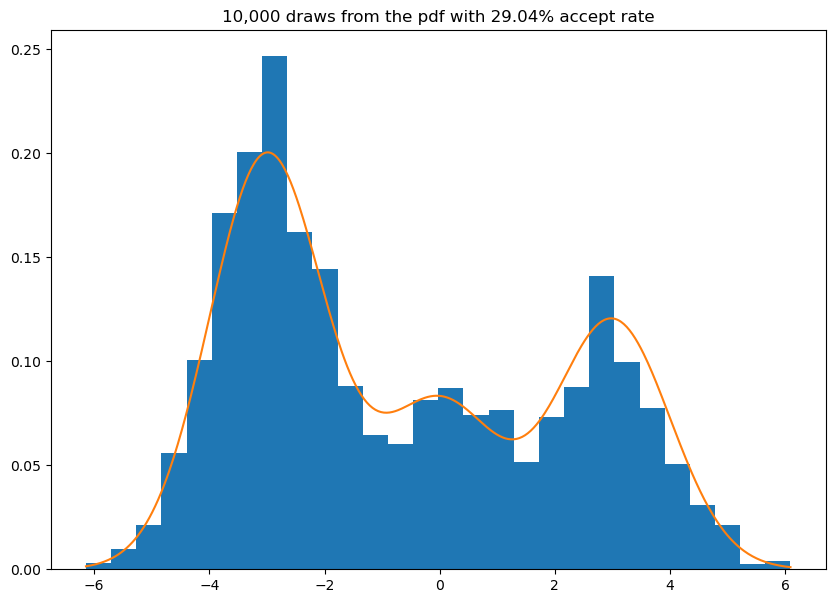

In [16]:
pdf = mixture_of_gaussians()
proposal_dist = st.norm(0, 10)

samples, accepts = gen_samples(10_000, metropolis_hastings(pdf, proposal_dist))

fig, ax = plt.subplots(figsize=(10, 7))

t = np.linspace(samples.min(), samples.max(), 500)
ax.hist(samples, bins='auto', density=True)
ax.plot(t, pdf(t))

ax.set_title(f'{samples.size:,d} draws from the pdf with {100 * accepts / samples.size :.2f}% accept rate');

### Exercise: Random Walk Metropolis-Hastings

This implementation is wildly inefficient! We will speed it up by fixing the proposal distribution as a Gaussian centered at the previous point (this is fairly standard). Specifically,
$$x_{t+1} \sim \mathcal{N}( x_t, \sigma),$$
so
$$\operatorname{prop}(x_{t+1} | x_{t}) = \mathcal{N}(x_{t + 1} | x_t, \sigma)$$

We call $\sigma$ the *step size*.

1. The Metropolis-Hastings acceptance criteria simplifies quite a bit - work out what $A(x_{t + 1} | x_t)$ is now.
2. scipy.stats is doing a lot of work: `st.norm().rvs()` is ~1000x slower than `np.random.randn()`. Rewrite `metropolis_hastings` with the acceptance criteria, and without using `st.norm().rvs()` to provide proposals.

In [17]:
def rw_metropolis_hastings(pdf, proposal_sd, init=0):
    current = init
    while True:
        prop = current + np.random.randn() * proposal_sd
        # prop = st.norm(current, proposal_sd).rvs()
        p_accept = min(1, pdf(prop) / pdf(current))
        accept = np.random.rand() < p_accept
        if accept:
            current = prop
        
        yield current, accept

Text(0.5, 1.0, '40,000 draws from the pdf with 94.68% accept rate')

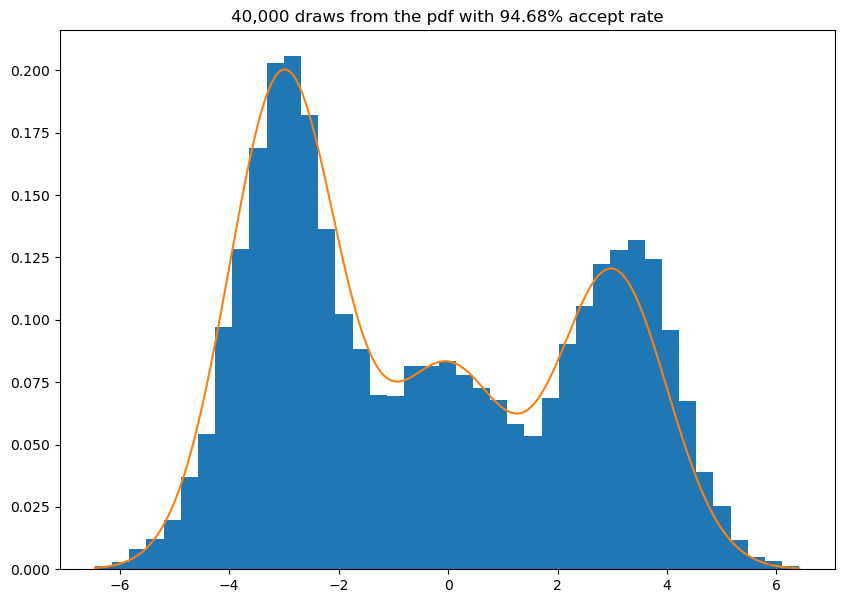

In [18]:
pdf = mixture_of_gaussians()

samples, accepts = gen_samples(40_000, rw_metropolis_hastings(pdf, 0.25))

fig, ax = plt.subplots(figsize=(10, 7))

t = np.linspace(samples.min(), samples.max(), 500)
ax.hist(samples, bins='auto', density=True)
ax.plot(t, pdf(t))

ax.set_title(f'{samples.size:,d} draws from the pdf with {100 * accepts / samples.size :.2f}% accept rate')

### MCMC Exercises 2

1. Find a step size so that the acceptance rate is ~25%
2. Find a step size so that the acceptance rate is ~95%
3. What is the general relationship between step size and acceptance rate?

### Bonus exercise

Write a routine for finding a step size that gives a specific acceptance rate for Metropolis-Hastings. It may be helpful to return the acceptance probability instead of (or in addition to) the `accept` boolean. Literature suggests the overly specific 23.4% acceptance rate as a good target. PyMC aims for anything between 20% and 50%.

## Gibbs Sampling

If you can sample from all the marginal distributions, you can implement a sampler pretty efficiently just using those.

Here is a stereotypical Gibbs sampling algorithm:

1.  Choose starting values for states (parameters):
    ${\bf \theta} = [\theta_1^{(0)},\theta_2^{(0)},\ldots,\theta_k^{(0)}]$

2.  Initialize counter $j=1$

3.  Draw the following values from each of the $k$ conditional
    distributions:

$$\begin{aligned}
\theta_1^{(j)} &\sim& \pi(\theta_1 | \theta_2^{(j-1)},\theta_3^{(j-1)},\ldots,\theta_{k-1}^{(j-1)},\theta_k^{(j-1)}) \\
\theta_2^{(j)} &\sim& \pi(\theta_2 | \theta_1^{(j)},\theta_3^{(j-1)},\ldots,\theta_{k-1}^{(j-1)},\theta_k^{(j-1)}) \\
\theta_3^{(j)} &\sim& \pi(\theta_3 | \theta_1^{(j)},\theta_2^{(j)},\ldots,\theta_{k-1}^{(j-1)},\theta_k^{(j-1)}) \\
\vdots \\
\theta_{k-1}^{(j)} &\sim& \pi(\theta_{k-1} | \theta_1^{(j)},\theta_2^{(j)},\ldots,\theta_{k-2}^{(j)},\theta_k^{(j-1)}) \\
\theta_k^{(j)} &\sim& \pi(\theta_k | \theta_1^{(j)},\theta_2^{(j)},\theta_4^{(j)},\ldots,\theta_{k-2}^{(j)},\theta_{k-1}^{(j)})
\end{aligned}$$

4.  Increment $j$ and repeat until convergence occurs.

This is pretty tricky to automate, since you need to know all of these conditional distributions! That said, this is often seen in science when a sampler is hand-built to do inference with a specific model. In that case, each conditional distribution might be computed by hand.

### Coal mining example
We have a time series of recorded coal mining disasters in the UK from 1851 to 1961.

Occurrences of disasters in the time series is thought to be derived from a Poisson process with a large rate parameter in the early part of the time series, and from one with a smaller rate in the later part. We are interested in locating the change point in the series, which perhaps is related to changes in mining safety regulations.


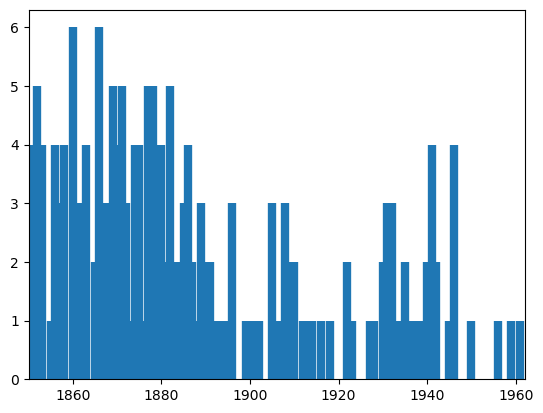

In [19]:
disasters_array = np.array(
    [4, 5, 4, 0, 1, 4, 3, 4, 0, 6, 3, 3, 4, 0, 2, 6, 3, 3, 5, 4, 5, 3, 
     1, 4, 4, 1, 5, 5, 3, 4, 2, 5, 2, 2, 3, 4, 2, 1, 3, 2, 2, 1, 1, 1, 
     1, 3, 0, 0, 1, 0, 1, 1, 0, 0, 3, 1, 0, 3, 2, 2, 0, 1, 1, 1, 0, 1, 
     0, 1, 0, 0, 0, 2, 1, 0, 0, 0, 1, 1, 0, 2, 3, 3, 1, 1, 2, 1, 1, 1, 
     1, 2, 4, 2, 0, 0, 1, 4, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 
     1])
years = np.arange(1851, 1962, dtype=int)

fig, ax = plt.subplots()
ax.vlines(years, 0, disasters_array, lw=6)
ax.set_xlim(years.min() - 1, years.max() + 1)
ax.set_ylim(bottom=0);

### Writing down the model and computing conditional distributions

Let's step through the construction of a model for this problem, starting with the likelihood.
It is natural to use a Poisson distribution for this type of count data. Denoting year $i$'s accident count by $y_i$, 

$$ y_i \sim \text{Poisson}(\lambda)  $$

The modeling problem revolves around estimating the values of the $\lambda$ parameters. Looking at the time series above, it appears that the rate declines later in the time series.

A ***changepoint model*** identifies a point (year) during the observation period (call it $\tau$) after which the parameter $\lambda$ drops to a lower value. So we are estimating two $\lambda$ parameters: one for the early period and another for the late period.

$$
\lambda = 
\begin{cases}
\lambda_1  & \text{if } t \lt \tau \cr
\lambda_2 & \text{if } t \ge \tau
\end{cases}
$$

We need to assign prior probabilities to both $\lambda$ parameters. The gamma distribution not only provides a continuous density function for positive numbers, but it is also **conjugate** with the Poisson sampling distribution. We will specify suitably vague hyperparameters $\alpha$ and $\beta$ for both priors.

$$\begin{aligned}
\lambda_1 &\sim \text{Gamma}( \alpha, \beta ) \cr
\lambda_2 &\sim \text{Gamma}( \alpha, \beta )
\end{aligned}$$

Since we do not have any intuition about the location of the changepoint (prior to viewing the data), we will assign a discrete uniform prior over all years 1851-1962.

$$\begin{aligned}
& \tau \sim \text{DiscreteUniform(1851,1962) }\cr
& \Rightarrow P( \tau = k ) = \frac{1}{111}
\end{aligned}$$

Now that we've specified the model (the hard part), let's implement it in PyMC (the easy part). We will use this to compare a hand-written Gibbs sampler.

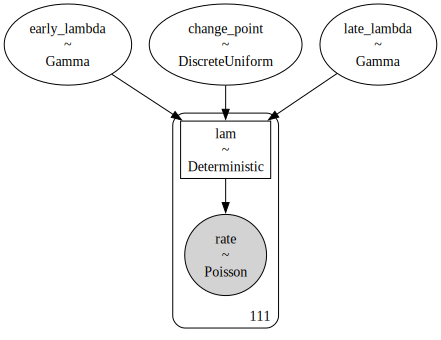

In [20]:
import pymc as pm

def coal_disaster_model():

    with pm.Model() as model:
        early_lambda = pm.Gamma('early_lambda', 1, 10)
        late_lambda = pm.Gamma('late_lambda', 1, 10)
        change_point = pm.DiscreteUniform('change_point', 1851, 1962)
        
        lam = pm.Deterministic('lam', pm.math.switch(years > change_point, late_lambda, early_lambda))
        pm.Poisson('rate', lam, observed=disasters_array)

    return model

pm.model_to_graphviz(coal_disaster_model())

### Implementing Gibbs sampling

We are interested in estimating the joint posterior of $\lambda_1$, $\lambda_2$ and $\tau$ given the array of annnual disaster counts $\mathbf{y}$. This gives:

$$
 P( \lambda_1, \lambda_2, \tau | \mathbf{y} ) \propto P(\mathbf{y} | \lambda_1, \lambda_2, \tau ) P(\lambda_1, \lambda_2, \tau) 
$$

To employ Gibbs sampling, we need to factor the joint posterior into the product of conditional expressions:

$$
 P( \lambda_1, \lambda_2, \tau | \mathbf{y} ) \propto P(y_{t<\tau} | \lambda_1, \tau) P(y_{t\ge \tau} | \lambda_2, \tau) P(\lambda_1) P(\lambda_2) P(\tau)
$$

which we have specified as:

$$\begin{aligned}
P( \lambda_1, \lambda_2, \tau | \mathbf{y} ) &\propto \left[\prod_{t=1851}^{\tau} \text{Poi}(y_t|\lambda_1) \prod_{t=\tau+1}^{1962} \text{Poi}(y_t|\lambda_2) \right] \text{Gamma}(\lambda_1|\alpha,\beta) \text{Gamma}(\lambda_2|\alpha, \beta) \frac{1}{111} \\
&\propto \left[\prod_{t=1851}^{\tau} e^{-\lambda_1}\lambda_1^{y_t} \prod_{t=\tau+1}^{1962} e^{-\lambda_2} \lambda_2^{y_t} \right] \lambda_1^{\alpha-1} e^{-\beta\lambda_1} \lambda_2^{\alpha-1} e^{-\beta\lambda_2} \\
&\propto \lambda_1^{\sum_{t=1851}^{\tau} y_t +\alpha-1} e^{-(\beta+\tau)\lambda_1} \lambda_2^{\sum_{t=\tau+1}^{1962} y_i + \alpha-1} e^{-\beta\lambda_2}
\end{aligned}$$

So, the full conditionals are known, and critically for Gibbs, can easily be sampled from.

$$\lambda_1 \sim \text{Gamma}(\sum_{t=1851}^{\tau} y_t +\alpha, \tau+\beta)$$
$$\lambda_2 \sim \text{Gamma}(\sum_{t=\tau+1}^{1962} y_i + \alpha, 1962-\tau+\beta)$$
$$\tau \sim \text{Categorical}\left( \frac{\lambda_1^{\sum_{t=1851}^{\tau} y_t +\alpha-1} e^{-(\beta+\tau)\lambda_1} \lambda_2^{\sum_{t=\tau+1}^{1962} y_i + \alpha-1} e^{-\beta\lambda_2}}{\sum_{k=1851}^{1962} \lambda_1^{\sum_{t=1851}^{\tau} y_t +\alpha-1} e^{-(\beta+\tau)\lambda_1} \lambda_2^{\sum_{t=\tau+1}^{1962} y_i + \alpha-1} e^{-\beta\lambda_2}} \right)$$

Implementing this in Python requires random number generators for both the gamma and discrete uniform distributions. We can leverage NumPy for this:

So far so good! Now here's an implementation!

In [21]:
def gibbs_sample_disaster(samples, tau=1900, early_lambda=6, late_lambda=2):
    """Can supply different initial conditions!"""
    draws = np.empty((3, samples))
    gamma_pdf = lambda lam, a, b: lam**(a-1) * np.exp(-b*lam)
    n_years = disasters_array.shape[0]
    years = np.arange(1851, 1962, dtype=int)
    draws = []
    while len(draws) < samples:
        # update early_lambda
        early_lambda = np.random.gamma(disasters_array[:tau - 1851].sum() + 1, 1 / (tau - 1851 + 10))
        draws.append([early_lambda, late_lambda, tau])
        
        # update late_lambda
        late_lambda = np.random.gamma(disasters_array[tau - 1851 + 1:].sum() + 1, 1 / (1962 - tau + 10))
        draws.append([early_lambda, late_lambda, tau])
        
        # update tau
        tau_probs = np.empty(n_years)
        for t in range(n_years):
            tau_probs[t] = (gamma_pdf(early_lambda, disasters_array[:t].sum() + 1, t + 10) *
                            gamma_pdf(late_lambda, disasters_array[t:].sum() + 1, n_years - t + 10))
        tau = np.random.choice(years, p=tau_probs / tau_probs.sum())
        draws.append([early_lambda, late_lambda, tau])
    return np.array(draws)[:samples]


### Checking our work

We compare the Gibbs sampler to the PyMC model -- this one runs faster, but took longer to write!

In [22]:
%%time
draws = gibbs_sample_disaster(1000)
draws.mean(axis=0) # early_lambda, late_lambda, change_point

CPU times: user 331 ms, sys: 8.95 ms, total: 340 ms
Wall time: 342 ms


array([2.48343033e+00, 7.89610134e-01, 1.89307400e+03])

In [23]:
%%time
with coal_disaster_model():
    trace = pm.sample()

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [early_lambda, late_lambda]
>Metropolis: [change_point]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


CPU times: user 2.42 s, sys: 281 ms, total: 2.7 s
Wall time: 20.1 s


In [24]:
import arviz as az

az.summary(trace, var_names=['early_lambda', 'late_lambda', 'change_point', ])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
early_lambda,2.471,0.226,2.044,2.888,0.004,0.003,2913.0,2866.0,1.0
late_lambda,0.814,0.105,0.612,1.001,0.002,0.001,2748.0,2473.0,1.0
change_point,1891.974,2.830,1886.000,1896.000,0.120,0.085,551.0,697.0,1.0


## Hamiltonian Monte Carlo

While flexible and easy to implement, Metropolis-Hastings (and Gibbs) sampling is a random walk
sampler that might not be statistically efficient for many models. Specifically, for models of high dimension, random walk jumping algorithms do not perform well. It is not enough to simply guess at the next sample location; we need to make each iteration a useful draw from the posterior whenever we can, in order to have an efficient sampler for bigger models.

Since Bayesian inference is all about calculating expectations over posteriors, what we seek is an algorithm that explores the area of the parameter space that contains most of the non-zero probability. This region is called the **typical set**.

### What's a Typical Set?

The typical set is where most of the probability density (mass) lies in a particular volume associated with the distribution. As the dimension of a model increases, this set moves progressively further from the mode, and becomes more singular, as the result of concentration of measure.

The typical set is a product of both the density, which is highest at the mode, and volume (that we integrate over), which increasingly becomes larger away from the mode as dimensionality increases. In fact, at high dimensions, the region around the mode contributes almost nothing to the expectation. We need an algorithm that will find this narrow region and explore it efficiently.

![from Hoffman and Gelman 2014](http://d.pr/i/RAA+)

In this context, and when sampling from continuous variables, Hamiltonian (or Hybrid) Monte
Carlo (HMC) can prove to be a powerful tool. It avoids
random walk behavior by simulating a physical system governed by
Hamiltonian dynamics, potentially avoiding tricky conditional
distributions in the process.

In HMC, model samples are obtained by simulating a physical system,
where particles move about a high-dimensional landscape, subject to
potential and kinetic energies. Adapting the notation from [Neal (1993)](http://www.cs.toronto.edu/~radford/review.abstract.html),
particles are characterized by a position vector or state
$s \in \mathcal{R}^D$ and velocity vector $\phi \in \mathcal{R}^D$. The
combined state of a particle is denoted as $\chi=(s,\phi)$. 

The joint **canonical distribution** of the position and velocity can be expressed as a product of the marginal position (which is of interest) and the conditional distribution of the velocity:

$$\pi(s, \phi) = \pi(\phi | s) \pi(s)$$

This joint probability can also be written in terms of an invariant **Hamiltonian function**:

$$\pi(s, \phi) \propto \exp(-H(s,\phi))$$

The Hamiltonian is then defined as the sum of potential energy $E(s)$ and kinetic energy
$K(\phi)$, as follows:

$$\mathcal{H}(s,\phi) = E(s) + K(\phi)
= E(s) + \frac{1}{2} \sum_i \phi_i^2$$

Instead of sampling $p(s)$ directly, HMC operates by sampling from the canonical distribution.

$$p(s,\phi) = \frac{1}{Z} \exp(-\mathcal{H}(s,\phi))=p(s)p(\phi)$$

If we choose a momentum that is independent of position, marginalizing over $\phi$ is
trivial and recovers the original distribution of interest.

Note that the Hamiltonian $\mathcal{H}$ is independent of the parameterization of the model, and therefore, captures the geometry of the phase space distribution, including typical set. 

**Hamiltonian Dynamics**

State $s$ and velocity $\phi$ are modified such that
$\mathcal{H}(s,\phi)$ remains constant throughout the simulation. The
differential equations are given by:

$$\begin{aligned}\frac{ds_i}{dt} &= \frac{\partial \mathcal{H}}{\partial \phi_i} = \phi_i \\
\frac{d\phi_i}{dt} &= - \frac{\partial \mathcal{H}}{\partial s_i}
= - \frac{\partial E}{\partial s_i}
\end{aligned}$$

As shown in [Neal (1993)](http://www.cs.toronto.edu/~radford/review.abstract.html), 
the above transformation preserves volume and is
reversible. The above dynamics can thus be used as transition operators
of a Markov chain and will leave $p(s,\phi)$ invariant. That chain by
itself is not ergodic however, since simulating the dynamics maintains a
fixed Hamiltonian $\mathcal{H}(s,\phi)$. HMC thus alternates Hamiltonian
dynamic steps, with Gibbs sampling of the velocity. Because $p(s)$ and
$p(\phi)$ are independent, sampling $\phi_{new} \sim p(\phi|s)$ is
trivial since $p(\phi|s)=p(\phi)$, where $p(\phi)$ is often taken to be
the univariate Gaussian.

![Skate park](images/skate_park.png?raw=true)

**The Leap-Frog Algorithm**

In practice, we cannot simulate Hamiltonian dynamics exactly because of
the problem of time discretization. There are several ways one can do
this. To maintain invariance of the Markov chain however, care must be
taken to preserve the properties of *volume conservation* and *time
reversibility*. The **leap-frog algorithm** maintains these properties
and operates in 3 steps:

$$\begin{aligned}
\phi_i(t + \epsilon/2) &= \phi_i(t) - \frac{\epsilon}{2} \frac{\partial{}}{\partial s_i} E(s(t)) \\
s_i(t + \epsilon) &= s_i(t) + \epsilon \phi_i(t + \epsilon/2) \\
\phi_i(t + \epsilon) &= \phi_i(t + \epsilon/2) - \frac{\epsilon}{2} \frac{\partial{}}{\partial s_i} E(s(t + \epsilon)) 
\end{aligned}$$

We thus perform a half-step update of the velocity at time
$t+\epsilon/2$, which is then used to compute $s(t + \epsilon)$ and
$\phi(t + \epsilon)$.

**Accept / Reject**

In practice, using finite stepsizes $\epsilon$ will not preserve
$\mathcal{H}(s,\phi)$ exactly and will introduce bias in the simulation.
Also, rounding errors due to the use of floating point numbers means
that the above transformation will not be perfectly reversible.

HMC cancels these effects **exactly** by adding a Metropolis
accept/reject stage, after $n$ leapfrog steps. The new state
$\chi' = (s',\phi')$ is accepted with probability $p_{acc}(\chi,\chi')$,
defined as:

$$p_{acc}(\chi,\chi') = min \left( 1, \frac{\exp(-\mathcal{H}(s',\phi')}{\exp(-\mathcal{H}(s,\phi)} \right)$$

**HMC Algorithm**

We obtain a new HMC sample as follows:

1.  sample a new velocity from a univariate Gaussian distribution
2.  perform $n$ leapfrog steps to obtain the new state $\chi'$
3.  perform accept/reject move of $\chi'$

---
## References

Doucet, A., De Freitas, N., and Gordon, N. (2001), Sequential Monte Carlo Methods in Practice, Statistics for Engineering and Information Science, New York: Springer-Verlag.

Chapter 6 of [Givens, Geof H.; Hoeting, Jennifer A. (2012-10-09). Computational Statistics (Wiley Series in Computational Statistics)](http://www.stat.colostate.edu/computationalstatistics/)

Chapter 5 of [Albert, J. (2009). Bayesian computation with R.](http://www.amazon.com/Bayesian-Computation-R-Use/dp/0387922970)

Gelman, A., Carlin, J. B., Stern, H. S., & Rubin, D. B. (2003). Bayesian Data Analysis, Second Edition (Chapman & Hall/CRC Texts in Statistical Science) (2nd ed.). Chapman and Hall/CRC.

Neal, R. M. (2003). Slice sampling. The Annals of Statistics, 31(3), 705–767. doi:10.1111/1467-9868.00198